In [36]:
# Libraries for working with multidimensional arrays
# https://ecmwf-projects.github.io/copernicus-training-c3s/reanalysis-climatology.html
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature#
import cdsapi
# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()
import os

In [49]:
#fin_era5 = "era5-t2m-20210129.grib2"

#ds = xr.open_dataset(fin_era5)
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = os.getenv("CDS_API_KEY")
KEY = os.getenv("CDS_UID")
c = cdsapi.Client()
#c = cdsapi.Client(url=URL, key=KEY)
DATADIR = './'

area_europe = [72, -25, 34,40]
years = ["2020","2021"]

In [51]:
c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': '2m_temperature',
        'year': years,
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
        'area': area_europe,
        'format': 'netcdf',
    },
    f'{DATADIR}era5_monthly_t2m_eur.nc')


2023-06-08 20:50:44,944 INFO Welcome to the CDS
2023-06-08 20:50:44,945 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-06-08 20:50:45,030 INFO Request is queued
2023-06-08 20:50:46,095 INFO Request is running
2023-06-08 20:50:53,397 INFO Request is completed
2023-06-08 20:50:53,398 INFO Downloading https://download-0004-clone.copernicus-climate.eu/cache-compute-0004/cache/data4/adaptor.mars.internal-1686250252.8572686-13266-5-2ac9ef41-eaea-420f-b439-8e5239b846d0.nc to ./era5_monthly_t2m_eur.nc (1.8M)
2023-06-08 20:50:54,211 INFO Download rate 2.3M/s   


Result(content_length=1919608,content_type=application/x-netcdf,location=https://download-0004-clone.copernicus-climate.eu/cache-compute-0004/cache/data4/adaptor.mars.internal-1686250252.8572686-13266-5-2ac9ef41-eaea-420f-b439-8e5239b846d0.nc)

In [75]:
t2m = f'{DATADIR}era5_monthly_t2m_eur.nc'
ds = xr.open_dataset(t2m)
ds
type(ds)

xarray.core.dataset.Dataset

In [76]:
import metview as mv
fin_carra="t2m-mean_carra-20210101-20210131.grib2"
carra = mv.read(fin_carra)
carra_ds = carra.to_dataset()

Ignoring index file '/home/cap/data/scripts/dataviz/metviz/python/carra/t2m-mean_carra-20210101-20210131.grib2.923a8.idx' incompatible with GRIB file


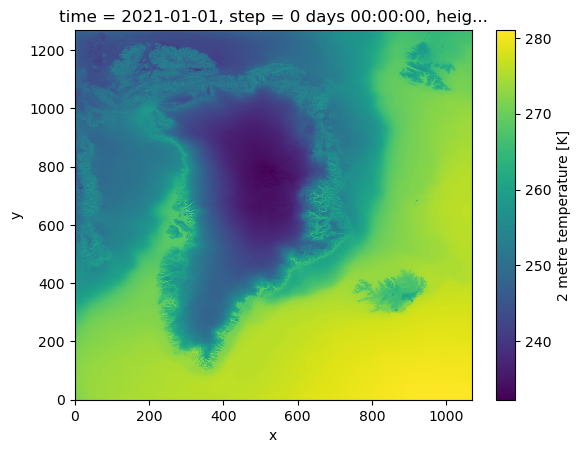

In [81]:
carra_ds["t2m"].plot()

In [64]:
import copy
import pygrib
import numpy.ma as ma
import datetime

def read_vars(gribfile,params):
    '''
    Reads a file that contains only one time step
    '''
    print("in read_vars")
    ds = {}
    vars = copy.deepcopy(params)
    f = pygrib.open(gribfile)
    was_found=False
    for msg in f:
        for param in vars:
            if vars[param]['param']== str(msg['param']) and vars[param]["level"]==msg["level"] and vars[param]["typeOfLevel"]==msg['typeOfLevel'] and vars[param]["levelType"]==msg["levelType"]:
                print(f'found {vars[param]}')
                vars[param]['msg'] = msg
                was_found=True
        if not was_found:
            #quick check for when it doesnt find anything
            for param in vars:
                print(vars[param]['param'])
                if vars[param]['param']== str(msg['param']):
                    print(f"{param} not found. Printing some info")
                    this_param=msg["param"]
                    this_level=msg["level"]
                    this_tlevel=msg['typeOfLevel']
                    this_ltype=msg["levelType"]
                    print("level :{this_level}")
                    print("typeOfLevel {this_tlevel}")
                    print("levelType {this_ltype}")
                    print("Original params:")
                    print(params)
                    for key in ["param","level","typeOfLevel","levelType"]:
                        new_params = {param:{"param":this_param,"level":this_level,
                                             "typeOfLevel":this_tlevel,"levelType":this_ltype}}
                    print(new_params)
                    sys.exit(0)

    for param in vars:
        msghit = vars[param]['msg']
        nx = msghit['Nx']
        ny = msghit['Ny']
        date = msghit['date']
        hour = msghit['hour']
        fcstep = msghit['step']
        lons = msghit['longitudes'].reshape((ny,nx))
        lats = msghit['latitudes'].reshape((ny,nx))
        lat0 = msghit['LaDInDegrees']
        lon0 = msghit['LoVInDegrees']
        lat1 = msghit['Latin1InDegrees']
        lat2 = msghit['Latin2InDegrees']
        val = ma.masked_values(msghit['values'].reshape((ny,nx)),msghit['missingValue'])
        name = msghit['parameterName']
        vars[param]['field'] = val
        dt = datetime.datetime.strptime(str(date)+str(hour),"%Y%m%d%H")
        lons2 = np.where(lons>180,lons-360,lons)
        lon0 = np.where(lon0>180,lon0-360,lon0)
        proj = ccrs.LambertConformal(central_latitude=lat0,
                                 central_longitude=lon0,
                                 standard_parallels=(lat1, lat2))
        ds['misc'] = {'date':dt,
                      'lons':lons2,
                      'lats':lats,
                      'proj':proj,
                      'fcstep':fcstep}
        ds['params'] = vars

    return ds



In [66]:
params = {'t2m':{"param":"167","level":2,"typeOfLevel":"heightAboveGround","levelType":"sfc"}}

ds_read = read_vars(t2m_carra,params)

in read_vars
found {'param': '167', 'level': 2, 'typeOfLevel': 'heightAboveGround', 'levelType': 'sfc'}


In [74]:
ds_read["params"]["t2m"]
ds_read["misc"]["lats"]
ds_carra=ds_read['params']["t2m"]['field'] - 273.15
ds_carra_xr = xr.Dataset

masked_array(
  data=[[ -2.04207458,  -2.00984802,  -1.9375824 , ...,   7.77530823,
           7.80558167,   7.75284729],
        [ -1.92586365,  -1.91023865,  -1.83504333, ...,   7.81534729,
           7.8514801 ,   7.83097229],
        [ -1.97469177,  -1.96785583,  -1.88484802, ...,   7.76847229,
           7.79874573,   7.78507385],
        ...,
        [-25.37801208, -25.43465271, -25.39656677, ...,  -7.05574646,
          -6.98348083,  -7.0235199 ],
        [-25.52547302, -25.59285583, -25.53426208, ...,  -7.1094574 ,
          -7.0391449 ,  -7.07234802],
        [-25.45223083, -25.57332458, -25.53035583, ...,  -7.06160583,
          -7.00496521,  -7.04402771]],
  mask=False,
  fill_value=9999.0)

In [54]:
t2m_carra="t2m-mean_carra-20210101-20210131.grib2"
ds_carra = xr.open_dataset(t2m_carra)
ds_carra

<xarray.Dataset>
Dimensions:            (y: 1269, x: 1069)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    t2m                (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             enmi
    GRIB_centreDescription:  Oslo
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Oslo
    history:                 2023-06-08T20:52 GRIB to CDM+CF via cfgrib-0.9.1...

In [44]:
ds_180 = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')


In [45]:
# Create Xarray Data Array
da = ds_180['t2m']

In [46]:
# Create Xarray Data Array
da_degc = ds['t2m'] - 273.15

In [8]:
da_degc = da - 273.15


In [47]:
da_degc = da_degc.assign_attrs(da.attrs)
da_degc.attrs['units'] = '° C'

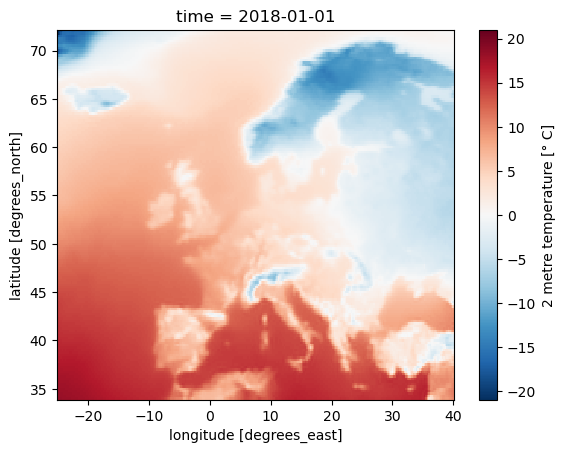

In [48]:
da_degc[0,:,:].plot()